# PCB Defect Detection - Model Visualization

Visualizing YOLOv8 model predictions on random samples from the test dataset.


In [1]:
import random
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Paths
BASE_DIR = Path(__file__).parent.parent if "__file__" in dir() else Path.cwd().parent
MODEL_PATH = BASE_DIR / "models" / "pcb_defects_yolov8m" / "best.pt"
TEST_IMAGES_DIR = BASE_DIR / "data" / "yolo_dataset" / "images" / "test"

# Class names and colors
CLASS_NAMES = ["missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper"]
CLASS_COLORS = {
    "missing_hole": "#FF6B6B",
    "mouse_bite": "#4ECDC4", 
    "open_circuit": "#45B7D1",
    "short": "#96CEB4",
    "spur": "#FFEAA7",
    "spurious_copper": "#DDA0DD"
}

print(f"Model path: {MODEL_PATH}")
print(f"Test images dir: {TEST_IMAGES_DIR}")
print(f"Model exists: {MODEL_PATH.exists()}")


Model path: /Users/bahacelik/Documents/Coding/Automated-Quality-Inspection-Station/models/pcb_defects_yolov8m/best.pt
Test images dir: /Users/bahacelik/Documents/Coding/Automated-Quality-Inspection-Station/data/yolo_dataset/images/test
Model exists: True


In [2]:
# Load the trained model
model = YOLO(MODEL_PATH)
print("✅ Model loaded successfully!")
print(f"Model type: {model.task}")


✅ Model loaded successfully!
Model type: detect


In [3]:
# Get a single test image with good detection results
test_images = list(TEST_IMAGES_DIR.glob("*.jpg"))
print(f"Total test images: {len(test_images)}")

# Select one image - preferring 'short' or 'spur' for clear visual results
selected_image = None
for class_name in ["short", "spur", "missing_hole"]:
    class_images = [img for img in test_images if class_name in img.name.lower()]
    if class_images:
        selected_image = random.choice(class_images)
        break

if selected_image is None:
    selected_image = random.choice(test_images)

print(f"\nSelected image: {selected_image.name}")


Total test images: 70

Selected image: Short_11_short_08.jpg


In [4]:
# Run inference on selected image
result = model.predict(
    source=selected_image,
    conf=0.25,  # Confidence threshold
    save=False,
    verbose=False
)[0]

print(f"✅ Inference complete")


✅ Inference complete


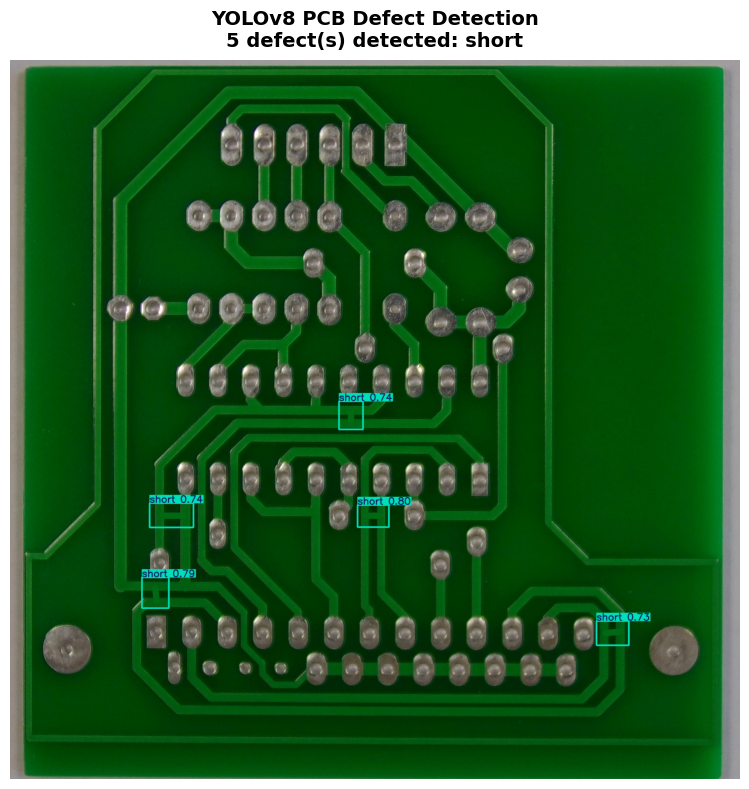

✅ Saved to PCB_Detection_Result.png


In [5]:
# Visualize single detection result (report-ready)
fig, ax = plt.subplots(figsize=(12, 8))

# Get the annotated image with bounding boxes
annotated_img = result.plot(
    conf=True,
    labels=True,
    line_width=3,
    font_size=12
)

# Convert BGR to RGB for matplotlib
annotated_img_rgb = annotated_img[:, :, ::-1]

ax.imshow(annotated_img_rgb)
ax.axis("off")

# Get detection summary
boxes = result.boxes
num_detections = len(boxes)
classes_detected = list(set([CLASS_NAMES[int(cls)] for cls in boxes.cls])) if num_detections > 0 else []

plt.title(f"YOLOv8 PCB Defect Detection\n{num_detections} defect(s) detected: {', '.join(classes_detected)}", 
          fontsize=14, fontweight="bold", pad=10)
plt.tight_layout()
plt.savefig(BASE_DIR / "PCB_Detection_Result.png", dpi=200, bbox_inches="tight", facecolor="white")
plt.show()
print(f"✅ Saved to PCB_Detection_Result.png")


In [6]:
# Print detailed detection information
img_name = Path(result.path).name
boxes = result.boxes

print("=" * 60)
print(f"DETECTION RESULTS: {img_name}")
print("=" * 60)

if len(boxes) > 0:
    for i, (box, conf, cls) in enumerate(zip(boxes.xyxy, boxes.conf, boxes.cls)):
        class_name = CLASS_NAMES[int(cls)]
        x1, y1, x2, y2 = box.tolist()
        print(f"  [{i+1}] {class_name:20s} | Conf: {conf:.3f} | Box: ({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})")
else:
    print("  No defects detected")

print("=" * 60)


DETECTION RESULTS: Short_11_short_08.jpg
  [1] short                | Conf: 0.802 | Box: (1087, 1392, 1185, 1461)
  [2] short                | Conf: 0.792 | Box: (413, 1619, 496, 1714)
  [3] short                | Conf: 0.744 | Box: (436, 1387, 573, 1462)
  [4] short                | Conf: 0.741 | Box: (1029, 1069, 1104, 1156)
  [5] short                | Conf: 0.726 | Box: (1834, 1755, 1934, 1831)


## Summary Statistics


In [7]:
# Summary statistics for single image
from collections import Counter

boxes = result.boxes
detections = [CLASS_NAMES[int(cls)] for cls in boxes.cls]
confidences = [float(conf) for conf in boxes.conf]
class_counts = Counter(detections)

print("📊 DETECTION SUMMARY")
print("=" * 50)
print(f"Total detections: {len(detections)}")
print(f"Average confidence: {sum(confidences)/len(confidences):.3f}" if confidences else "N/A")
print()
print("Detections by class:")
for class_name in CLASS_NAMES:
    count = class_counts.get(class_name, 0)
    if count > 0:
        bar = "█" * count
        print(f"  {class_name:20s}: {count:2d} {bar}")


📊 DETECTION SUMMARY
Total detections: 5
Average confidence: 0.761

Detections by class:
  short               :  5 █████
